# ライブラリ読み込み

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# utility
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import glob
import os
import sys
from sys import stderr

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# pytorch
# conda install pytorch torchvision -c pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# 囲碁ライブラリ
from sgfmill import sgf
from sgfmill import boards

# ルートに移動
%cd /Users/keimy/git/humanized-models-for-board-games/igo
%pwd


/Users/keimy/git/humanized-models-for-board-games/igo


'/Users/keimy/git/humanized-models-for-board-games/igo'

# Visualize Data

In [2]:
# .npy ファイルからデータをロード
# moves = np.load('./preprocess/arrays_at_move.npy')
moves = np.load('./preprocess/arrays_at_move.npz')['arr_0']

moves.shape

(33575793,)

In [9]:
from src.board import visualize_matrix

items = moves[200]
black_matrix, white_matrix = items["black_matrix"], items["white_matrix"]
visualize_matrix(black_matrix, white_matrix)


0

# Make Dataloaders

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomGoDataset(Dataset):
    def __init__(self, numpy_arrays):
        self.data = numpy_arrays

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        black_matrix = item['black_matrix']
        white_matrix = item['white_matrix']
        black_rank = item['black_rank']
        white_rank = item['white_rank']
        move = item['move']
        X = np.stack([black_matrix, white_matrix], axis=0)
        return X, black_rank, white_rank, move


# 元のデータセットをカスタムデータセットに変換
moves2 = CustomGoDataset(moves)

# データセットの分割
train_size = int(0.8 * len(moves2))
valid_size = len(moves2) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(moves2, [train_size, valid_size])

# DataLoaderの定義
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# DataLoaderを使ったデータの取得
for X, black_rank, white_rank, move in train_loader:
    print(f"Combined Matrix Shape: {X.shape}")
    print(f"Black Rank: {black_rank.shape}")
    print(f"White Rank: {white_rank.shape}")
    print(f"Move: {move.shape}")
    break


Combined Matrix Shape: torch.Size([1024, 2, 19, 19])
Black Rank: torch.Size([1024])
White Rank: torch.Size([1024])
Move: torch.Size([1024])


# VAE-linear

In [ ]:
from src.model.VAE_linear import VAE_linear
z_dim = 10
assert z_dim >= 2
input_dim =  2 * 19 * 19
n_epochs = 3

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_linear(z_dim = z_dim, input_dim = input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x in train_loader:
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in valid_loader:
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


任意のxをもとに可視化

xはバッチで投げればy,zもバッチで返ってくる


xを単体で投げた場合はバッチサイズ=1と解釈されて

y,zもバッチサイズ=1の次元になるのでスクイーズが必要

In [ ]:
model.eval()

for x in valid_loader:
    print(x.shape, x.dtype)
    x = x.float().to(device)

    # xはバッチで投げている
    y, z = model(x)
    y = y.cpu().detach().numpy()

    print(y.shape, z.shape)
    break


xを単体で投げる

In [ ]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

# x単体を投げる
y, z = model(x)
y = y.cpu().detach().numpy()


x.shape, y.shape, z.shape

In [ ]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

y, z = model(x)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)

print("reconstructed move")
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

print("original move")
black_matrix, white_matrix = x.squeeze()
visualize_matrix(black_matrix, white_matrix)

Zのランダムサンプリング

In [ ]:
z = torch.randn([1, z_dim]).to(device)

model.eval()
y = model._decoder(z)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

# VAE-CNN

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42
device = "mps" if torch.backends.mps.is_available() else "cpu"


class CNNEncoder(nn.Module):
    """ CNNベースのエンコーダ """
    def __init__(self, z_dim, h_dim=128, indim = (19, 19), c_init = 2, outdim_conv=8):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(c_init, 2, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(4, outdim_conv, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.fc1 = nn.Linear(outdim_conv * indim[0] * indim[1], h_dim)
        self.fc_mean = nn.Linear(h_dim, z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # x.size(0)はバッチサイズ
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x)
        # log_varは実数全部とるのでexp(log_var)すれば正数になる！
        log_var = self.fc_var(x)
        return mean, log_var


class CNNDecoder(nn.Module):
    """ CNNベースのデコーダ """
    def __init__(self, z_dim, h_dim=128, indim = (19, 19), c_init = 2, indim_deconv=8):
        super(CNNDecoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, indim_deconv * indim[0] * indim[1])

        self.deconv1 = nn.ConvTranspose2d(indim_deconv, 4, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(4, 4, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(4, 2, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose2d(2, c_init, kernel_size=3, stride=1, padding=1)

    def forward(self, z, indim = (19, 19), indim_deconv=8):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        # z.size(0)はバッチサイズ
        z = z.view(z.size(0), indim_deconv, indim[0], indim[1])
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        reconstruction = torch.sigmoid(self.deconv4(z))
        return reconstruction


class VAE_CNN(nn.Module):
    """ CNNベースのVAE """
    def __init__(self, z_dim=64, h_dim=128):
        super(VAE_CNN, self).__init__()
        self.encoder = CNNEncoder(z_dim, h_dim)
        self.decoder = CNNDecoder(z_dim, h_dim)

    def reparameterize(self, mean, log_var):
        # log_varは実数全部とるがexpすることで正数のみ(STDは正数じゃないといけない)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var
    

    def loss(self, x):
        # モデルのforwardパスを使用して、再構成されたデータ、平均、対数分散を取得
        recon_x, mean, log_var = self.forward(x)

        # 再構成誤差（バイナリクロスエントロピー）
        # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        BCE = F.binary_cross_entropy(recon_x, x, reduction='mean', size_average=False)

        # KLダイバージェンス
        # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        KLD = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

        return KLD, BCE  # KLダイバージェンスと再構成誤差を返す


学習

In [12]:
z_dim = 32
assert z_dim >= 2
n_epochs = 3
beta = 200

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_CNN(z_dim = z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for i, (x, black_rank, white_rank, move) in enumerate(tqdm(train_loader)):
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = beta * KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        # 学習曲線用にlossを保存
        # losses.append(loss.cpu().detach().numpy())
        # KL_losses.append(KL_loss.cpu().detach().numpy())
        # reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

        # ミニバッチごとに進捗を表示
        if i%500 == 0: print(f"{i} batch: {beta:.0f} * {KL_loss.item()/batch_size:.5f} + {reconstruction_loss.item()/batch_size:.0f}")


    losses_val = []
    model.eval()
    for x, black_rank, white_rank, move in tqdm(valid_loader):
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss

        # 学習曲線用にlossを保存
        # losses_val.append(loss.cpu().detach().numpy())


    # print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
        #   (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


  0%|          | 0/26232 [00:00<?, ?it/s]/Users/keimy/anaconda3/envs/world_model/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 2/26232 [00:01<5:27:41,  1.33it/s] 

0 batch: 200 * 0.00000 + 539


  2%|▏         | 505/26232 [00:21<16:18, 26.30it/s]

500 batch: 200 * 0.00353 + 223


  4%|▍         | 1004/26232 [00:39<15:23, 27.32it/s]

1000 batch: 200 * 0.00351 + 227


  6%|▌         | 1505/26232 [00:58<14:55, 27.63it/s]

1500 batch: 200 * 0.00372 + 220


  8%|▊         | 2004/26232 [01:17<15:06, 26.73it/s]

2000 batch: 200 * 0.00371 + 214


 10%|▉         | 2505/26232 [01:37<15:10, 26.05it/s]

2500 batch: 200 * 0.00366 + 205


 11%|█▏        | 3006/26232 [01:56<14:27, 26.77it/s]

3000 batch: 200 * 0.00378 + 210


 13%|█▎        | 3504/26232 [02:15<14:21, 26.39it/s]

3500 batch: 200 * 0.00375 + 208


 15%|█▌        | 4005/26232 [02:35<14:17, 25.91it/s]

4000 batch: 200 * 0.00372 + 202


 17%|█▋        | 4506/26232 [02:54<14:24, 25.14it/s]

4500 batch: 200 * 0.00370 + 203


 19%|█▉        | 5005/26232 [03:13<13:34, 26.07it/s]

5000 batch: 200 * 0.00376 + 199


 21%|██        | 5504/26232 [03:32<13:21, 25.86it/s]

5500 batch: 200 * 0.00369 + 199


 23%|██▎       | 6006/26232 [03:51<12:21, 27.28it/s]

6000 batch: 200 * 0.00371 + 202


 25%|██▍       | 6505/26232 [04:10<12:35, 26.10it/s]

6500 batch: 200 * 0.00374 + 204


 27%|██▋       | 7003/26232 [04:29<12:32, 25.56it/s]

7000 batch: 200 * 0.00373 + 206


 29%|██▊       | 7505/26232 [04:48<11:42, 26.66it/s]

7500 batch: 200 * 0.00379 + 206


 31%|███       | 8004/26232 [05:06<10:53, 27.91it/s]

8000 batch: 200 * 0.00375 + 199


 32%|███▏      | 8505/26232 [05:25<10:51, 27.20it/s]

8500 batch: 200 * 0.00378 + 200


 34%|███▍      | 9005/26232 [05:44<10:17, 27.89it/s]

9000 batch: 200 * 0.00373 + 199


 36%|███▌      | 9506/26232 [06:03<10:09, 27.43it/s]

9500 batch: 200 * 0.00378 + 198


 38%|███▊      | 10004/26232 [06:22<10:07, 26.73it/s]

10000 batch: 200 * 0.00378 + 201


 40%|████      | 10504/26232 [06:41<09:38, 27.17it/s]

10500 batch: 200 * 0.00377 + 199


 42%|████▏     | 11005/26232 [07:00<09:48, 25.86it/s]

11000 batch: 200 * 0.00377 + 205


 44%|████▍     | 11506/26232 [07:19<09:01, 27.20it/s]

11500 batch: 200 * 0.00376 + 200


 46%|████▌     | 12004/26232 [07:38<08:58, 26.40it/s]

12000 batch: 200 * 0.00380 + 198


 48%|████▊     | 12505/26232 [07:57<08:45, 26.10it/s]

12500 batch: 200 * 0.00379 + 207


 50%|████▉     | 13006/26232 [08:16<08:22, 26.29it/s]

13000 batch: 200 * 0.00383 + 202


 51%|█████▏    | 13504/26232 [08:35<08:06, 26.14it/s]

13500 batch: 200 * 0.00378 + 197


 53%|█████▎    | 14006/26232 [08:54<09:27, 21.54it/s]

14000 batch: 200 * 0.00379 + 193


 55%|█████▌    | 14506/26232 [09:13<07:36, 25.71it/s]

14500 batch: 200 * 0.00387 + 204


 57%|█████▋    | 15004/26232 [09:32<07:06, 26.32it/s]

15000 batch: 200 * 0.00382 + 205


 59%|█████▉    | 15505/26232 [09:52<06:42, 26.66it/s]

15500 batch: 200 * 0.00385 + 200


 61%|██████    | 16004/26232 [10:11<06:25, 26.51it/s]

16000 batch: 200 * 0.00380 + 195


 63%|██████▎   | 16505/26232 [10:30<06:02, 26.81it/s]

16500 batch: 200 * 0.00381 + 202


 65%|██████▍   | 17005/26232 [10:49<05:49, 26.37it/s]

17000 batch: 200 * 0.00383 + 202


 67%|██████▋   | 17504/26232 [11:08<05:28, 26.58it/s]

17500 batch: 200 * 0.00384 + 195


 69%|██████▊   | 18004/26232 [11:27<05:15, 26.06it/s]

18000 batch: 200 * 0.00386 + 201


 71%|███████   | 18506/26232 [11:46<04:45, 27.05it/s]

18500 batch: 200 * 0.00385 + 197


 72%|███████▏  | 19005/26232 [12:05<04:33, 26.45it/s]

19000 batch: 200 * 0.00384 + 203


 74%|███████▍  | 19506/26232 [12:24<04:16, 26.26it/s]

19500 batch: 200 * 0.00383 + 206


 76%|███████▋  | 20004/26232 [12:43<03:46, 27.50it/s]

20000 batch: 200 * 0.00389 + 198


 78%|███████▊  | 20504/26232 [13:02<03:37, 26.32it/s]

20500 batch: 200 * 0.00390 + 198


 80%|████████  | 21004/26232 [13:21<03:12, 27.19it/s]

21000 batch: 200 * 0.00385 + 197


 82%|████████▏ | 21506/26232 [13:40<02:49, 27.94it/s]

21500 batch: 200 * 0.00382 + 195


 84%|████████▍ | 22004/26232 [13:59<02:37, 26.84it/s]

22000 batch: 200 * 0.00392 + 199


 86%|████████▌ | 22505/26232 [14:18<02:18, 26.89it/s]

22500 batch: 200 * 0.00388 + 196


 88%|████████▊ | 23006/26232 [14:37<01:59, 27.09it/s]

23000 batch: 200 * 0.00392 + 199


 90%|████████▉ | 23505/26232 [14:56<01:43, 26.45it/s]

23500 batch: 200 * 0.00388 + 193


 92%|█████████▏| 24006/26232 [15:15<01:20, 27.67it/s]

24000 batch: 200 * 0.00389 + 190


 93%|█████████▎| 24506/26232 [15:34<01:04, 26.84it/s]

24500 batch: 200 * 0.00391 + 198


 95%|█████████▌| 25005/26232 [15:53<00:54, 22.41it/s]

25000 batch: 200 * 0.00391 + 196


 97%|█████████▋| 25506/26232 [16:11<00:27, 26.46it/s]

25500 batch: 200 * 0.00394 + 195


 99%|█████████▉| 26004/26232 [16:31<00:08, 26.36it/s]

26000 batch: 200 * 0.00392 + 193


  0%|          | 1/26232 [00:00<7:14:50,  1.01it/s]

0 batch: 200 * 0.00388 + 196


  2%|▏         | 504/26232 [00:19<15:32, 27.60it/s]

500 batch: 200 * 0.00391 + 194


  4%|▍         | 1004/26232 [00:38<16:00, 26.28it/s]

1000 batch: 200 * 0.00393 + 195


  6%|▌         | 1504/26232 [00:56<27:17, 15.10it/s]

1500 batch: 200 * 0.00392 + 197


  8%|▊         | 2006/26232 [01:14<14:18, 28.22it/s]

2000 batch: 200 * 0.00394 + 197


 10%|▉         | 2504/26232 [01:33<14:14, 27.76it/s]

2500 batch: 200 * 0.00394 + 197


 11%|█▏        | 3005/26232 [01:52<14:23, 26.89it/s]

3000 batch: 200 * 0.00398 + 194


 13%|█▎        | 3504/26232 [02:10<14:07, 26.80it/s]

3500 batch: 200 * 0.00396 + 196


 15%|█▌        | 4004/26232 [02:28<13:25, 27.60it/s]

4000 batch: 200 * 0.00398 + 194


 17%|█▋        | 4505/26232 [02:47<12:39, 28.59it/s]

4500 batch: 200 * 0.00397 + 197


 19%|█▉        | 5004/26232 [03:05<12:53, 27.44it/s]

5000 batch: 200 * 0.00397 + 190


 21%|██        | 5505/26232 [03:23<13:08, 26.30it/s]

5500 batch: 200 * 0.00396 + 195


 23%|██▎       | 6005/26232 [03:41<12:21, 27.29it/s]

6000 batch: 200 * 0.00400 + 200


 25%|██▍       | 6504/26232 [04:00<11:41, 28.13it/s]

6500 batch: 200 * 0.00401 + 190


 27%|██▋       | 7006/26232 [04:19<11:14, 28.52it/s]

7000 batch: 200 * 0.00401 + 191


 29%|██▊       | 7505/26232 [04:38<11:34, 26.96it/s]

7500 batch: 200 * 0.00397 + 197


 31%|███       | 8003/26232 [04:56<12:15, 24.79it/s]

8000 batch: 200 * 0.00399 + 188


 32%|███▏      | 8506/26232 [05:15<10:51, 27.23it/s]

8500 batch: 200 * 0.00401 + 200


 34%|███▍      | 9006/26232 [05:34<10:35, 27.11it/s]

9000 batch: 200 * 0.00399 + 192


 36%|███▌      | 9506/26232 [05:53<10:31, 26.50it/s]

9500 batch: 200 * 0.00400 + 187


 38%|███▊      | 10006/26232 [06:12<10:21, 26.10it/s]

10000 batch: 200 * 0.00406 + 198


 40%|████      | 10506/26232 [06:30<09:50, 26.64it/s]

10500 batch: 200 * 0.00401 + 190


 42%|████▏     | 11005/26232 [06:49<09:35, 26.46it/s]

11000 batch: 200 * 0.00405 + 195


 44%|████▍     | 11505/26232 [07:08<09:09, 26.83it/s]

11500 batch: 200 * 0.00406 + 195


 46%|████▌     | 12006/26232 [07:27<08:48, 26.90it/s]

12000 batch: 200 * 0.00405 + 191


 48%|████▊     | 12506/26232 [07:46<10:27, 21.88it/s]

12500 batch: 200 * 0.00403 + 198


 50%|████▉     | 13006/26232 [08:05<08:04, 27.28it/s]

13000 batch: 200 * 0.00403 + 188


 51%|█████▏    | 13504/26232 [08:24<07:52, 26.92it/s]

13500 batch: 200 * 0.00405 + 195


 53%|█████▎    | 14004/26232 [08:42<07:40, 26.56it/s]

14000 batch: 200 * 0.00409 + 197


 55%|█████▌    | 14504/26232 [09:01<07:26, 26.29it/s]

14500 batch: 200 * 0.00407 + 194


 57%|█████▋    | 15006/26232 [09:20<07:08, 26.19it/s]

15000 batch: 200 * 0.00411 + 193


 59%|█████▉    | 15506/26232 [09:39<06:27, 27.71it/s]

15500 batch: 200 * 0.00408 + 191


 61%|██████    | 16006/26232 [09:58<06:09, 27.69it/s]

16000 batch: 200 * 0.00412 + 194


 63%|██████▎   | 16504/26232 [10:17<06:07, 26.46it/s]

16500 batch: 200 * 0.00411 + 198


 65%|██████▍   | 17005/26232 [10:36<05:48, 26.45it/s]

17000 batch: 200 * 0.00410 + 191


 67%|██████▋   | 17506/26232 [10:55<05:28, 26.53it/s]

17500 batch: 200 * 0.00410 + 187


 69%|██████▊   | 18006/26232 [11:13<05:10, 26.51it/s]

18000 batch: 200 * 0.00411 + 190


 71%|███████   | 18504/26232 [11:33<04:50, 26.57it/s]

18500 batch: 200 * 0.00414 + 193


 72%|███████▏  | 19005/26232 [11:51<04:24, 27.28it/s]

19000 batch: 200 * 0.00410 + 187


 74%|███████▍  | 19506/26232 [12:10<04:07, 27.17it/s]

19500 batch: 200 * 0.00413 + 192


 76%|███████▋  | 20005/26232 [12:29<03:50, 27.07it/s]

20000 batch: 200 * 0.00409 + 186


 78%|███████▊  | 20504/26232 [12:48<03:36, 26.48it/s]

20500 batch: 200 * 0.00416 + 192


 80%|████████  | 21004/26232 [13:07<03:20, 26.12it/s]

21000 batch: 200 * 0.00417 + 192


 82%|████████▏ | 21504/26232 [13:25<02:58, 26.49it/s]

21500 batch: 200 * 0.00414 + 190


 84%|████████▍ | 22005/26232 [13:44<02:38, 26.59it/s]

22000 batch: 200 * 0.00418 + 194


 86%|████████▌ | 22505/26232 [14:03<02:25, 25.55it/s]

22500 batch: 200 * 0.00417 + 190


 88%|████████▊ | 23005/26232 [14:22<02:00, 26.69it/s]

23000 batch: 200 * 0.00413 + 191


 90%|████████▉ | 23505/26232 [14:41<01:42, 26.59it/s]

23500 batch: 200 * 0.00417 + 193


 92%|█████████▏| 24006/26232 [15:00<01:20, 27.50it/s]

24000 batch: 200 * 0.00421 + 188


 93%|█████████▎| 24505/26232 [15:19<01:03, 27.09it/s]

24500 batch: 200 * 0.00419 + 195


 95%|█████████▌| 25005/26232 [15:37<00:45, 26.90it/s]

25000 batch: 200 * 0.00423 + 188


 97%|█████████▋| 25506/26232 [15:57<00:27, 26.72it/s]

25500 batch: 200 * 0.00421 + 197


 99%|█████████▉| 26005/26232 [16:16<00:08, 27.32it/s]

26000 batch: 200 * 0.00420 + 194


  0%|          | 4/26232 [00:01<2:06:35,  3.45it/s]

0 batch: 200 * 0.00417 + 193


  2%|▏         | 506/26232 [00:20<16:58, 25.26it/s]

500 batch: 200 * 0.00421 + 189


  4%|▍         | 1005/26232 [00:39<15:36, 26.94it/s]

1000 batch: 200 * 0.00421 + 188


  6%|▌         | 1505/26232 [00:57<15:11, 27.14it/s]

1500 batch: 200 * 0.00428 + 190


  8%|▊         | 2006/26232 [01:16<15:06, 26.74it/s]

2000 batch: 200 * 0.00424 + 195


 10%|▉         | 2505/26232 [01:35<14:28, 27.31it/s]

2500 batch: 200 * 0.00425 + 189


 11%|█▏        | 3004/26232 [01:53<14:18, 27.05it/s]

3000 batch: 200 * 0.00428 + 192


 13%|█▎        | 3505/26232 [02:13<14:17, 26.51it/s]

3500 batch: 200 * 0.00428 + 197


 15%|█▌        | 4006/26232 [02:31<13:45, 26.91it/s]

4000 batch: 200 * 0.00425 + 190


 17%|█▋        | 4504/26232 [02:50<13:36, 26.61it/s]

4500 batch: 200 * 0.00426 + 189


 19%|█▉        | 5006/26232 [03:08<12:49, 27.59it/s]

5000 batch: 200 * 0.00430 + 193


 21%|██        | 5506/26232 [03:28<13:05, 26.38it/s]

5500 batch: 200 * 0.00431 + 182


 23%|██▎       | 6005/26232 [03:47<12:37, 26.71it/s]

6000 batch: 200 * 0.00430 + 192


 25%|██▍       | 6506/26232 [04:05<12:08, 27.07it/s]

6500 batch: 200 * 0.00432 + 186


 27%|██▋       | 7006/26232 [04:24<12:06, 26.45it/s]

7000 batch: 200 * 0.00431 + 189


 29%|██▊       | 7506/26232 [04:43<11:38, 26.81it/s]

7500 batch: 200 * 0.00430 + 195


 31%|███       | 8005/26232 [05:02<11:34, 26.23it/s]

8000 batch: 200 * 0.00430 + 193


 32%|███▏      | 8506/26232 [05:21<11:09, 26.49it/s]

8500 batch: 200 * 0.00428 + 190


 34%|███▍      | 9004/26232 [05:40<10:26, 27.49it/s]

9000 batch: 200 * 0.00429 + 187


 36%|███▌      | 9505/26232 [05:59<10:19, 26.98it/s]

9500 batch: 200 * 0.00431 + 190


 38%|███▊      | 10006/26232 [06:17<09:42, 27.84it/s]

10000 batch: 200 * 0.00431 + 183


 40%|████      | 10504/26232 [06:36<09:49, 26.67it/s]

10500 batch: 200 * 0.00430 + 186


 42%|████▏     | 11005/26232 [06:54<09:22, 27.06it/s]

11000 batch: 200 * 0.00431 + 192


 44%|████▍     | 11504/26232 [07:13<09:14, 26.55it/s]

11500 batch: 200 * 0.00435 + 193


 46%|████▌     | 12004/26232 [07:32<09:05, 26.07it/s]

12000 batch: 200 * 0.00435 + 190


 48%|████▊     | 12505/26232 [07:50<08:21, 27.39it/s]

12500 batch: 200 * 0.00435 + 182


 50%|████▉     | 13006/26232 [08:10<08:06, 27.21it/s]

13000 batch: 200 * 0.00431 + 183


 51%|█████▏    | 13505/26232 [08:28<07:55, 26.79it/s]

13500 batch: 200 * 0.00434 + 189


 53%|█████▎    | 14004/26232 [08:47<08:04, 25.22it/s]

14000 batch: 200 * 0.00438 + 191


 55%|█████▌    | 14505/26232 [09:08<07:31, 25.99it/s]

14500 batch: 200 * 0.00440 + 181


 57%|█████▋    | 15006/26232 [09:27<06:51, 27.27it/s]

15000 batch: 200 * 0.00433 + 191


 59%|█████▉    | 15504/26232 [09:46<06:45, 26.47it/s]

15500 batch: 200 * 0.00435 + 186


 61%|██████    | 16005/26232 [10:04<06:21, 26.78it/s]

16000 batch: 200 * 0.00436 + 184


 63%|██████▎   | 16506/26232 [10:24<06:08, 26.40it/s]

16500 batch: 200 * 0.00439 + 193


 65%|██████▍   | 17004/26232 [10:43<05:32, 27.75it/s]

17000 batch: 200 * 0.00437 + 191


 67%|██████▋   | 17505/26232 [11:02<06:01, 24.14it/s]

17500 batch: 200 * 0.00439 + 191


 69%|██████▊   | 18006/26232 [11:21<05:00, 27.37it/s]

18000 batch: 200 * 0.00441 + 184


 71%|███████   | 18505/26232 [11:40<04:55, 26.14it/s]

18500 batch: 200 * 0.00443 + 183


 72%|███████▏  | 19004/26232 [11:59<04:36, 26.17it/s]

19000 batch: 200 * 0.00443 + 185


 74%|███████▍  | 19506/26232 [12:19<08:16, 13.55it/s]

19500 batch: 200 * 0.00441 + 194


 76%|███████▋  | 20005/26232 [12:38<03:49, 27.09it/s]

20000 batch: 200 * 0.00444 + 198


 78%|███████▊  | 20504/26232 [12:56<03:38, 26.21it/s]

20500 batch: 200 * 0.00443 + 185


 80%|████████  | 21005/26232 [13:15<03:10, 27.40it/s]

21000 batch: 200 * 0.00442 + 190


 82%|████████▏ | 21506/26232 [13:35<03:05, 25.50it/s]

21500 batch: 200 * 0.00444 + 194


 84%|████████▍ | 22004/26232 [13:53<02:33, 27.54it/s]

22000 batch: 200 * 0.00444 + 186


 86%|████████▌ | 22505/26232 [14:13<02:42, 22.97it/s]

22500 batch: 200 * 0.00446 + 192


 88%|████████▊ | 23006/26232 [14:33<02:03, 26.10it/s]

23000 batch: 200 * 0.00448 + 186


 90%|████████▉ | 23504/26232 [14:52<01:46, 25.70it/s]

23500 batch: 200 * 0.00445 + 191


 92%|█████████▏| 24005/26232 [15:11<01:24, 26.34it/s]

24000 batch: 200 * 0.00448 + 194


 93%|█████████▎| 24506/26232 [15:30<01:10, 24.49it/s]

24500 batch: 200 * 0.00444 + 181


 95%|█████████▌| 25004/26232 [15:50<00:48, 25.45it/s]

25000 batch: 200 * 0.00447 + 190


 97%|█████████▋| 25505/26232 [16:10<00:26, 27.31it/s]

25500 batch: 200 * 0.00450 + 192


 99%|█████████▉| 26006/26232 [16:29<00:08, 27.12it/s]

26000 batch: 200 * 0.00449 + 192


100%|██████████| 6558/6558 [02:37<00:00, 41.75it/s]


学習すみモデルを保存

In [13]:
import torch
import datetime

# 現在の時刻を取得
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M')

# 保存するファイルのパスを設定
save_path = f"params/model_{current_time}.pth"

# モデルのパラメーターを保存
torch.save(model.state_dict(), save_path)

モデルを読み込み

In [ ]:
# モデルを読み込む
z_dim = 32
device = "mps" if torch.backends.mps.is_available() else "cpu"
save_path = "params/model_202401112108.pth"

model = VAE_CNN(z_dim = z_dim).to(device)
model.load_state_dict(torch.load(save_path))


# 再構成moveを可視化

In [14]:
from src.board import visualize_matrix

def threshold(arr, th=0.28):
    arr[arr >= th] = 1
    arr[arr < th] = 0
    return arr

def visualize_y(y, figname=None):
    black_matrix, white_matrix = y.squeeze()
    black_matrix_2 = black_matrix * ((black_matrix - white_matrix)>0).astype(int)
    white_matrix_2 = white_matrix * ((white_matrix - black_matrix)>0).astype(int)

    black_matrix_2 = threshold(black_matrix_2)
    white_matrix_2 = threshold(white_matrix_2)

    visualize_matrix(black_matrix_2, white_matrix_2, figname=figname)  
    return 0

def visualize_x(x, figname=None):
    black_matrix, white_matrix = x.squeeze()
    visualize_matrix(black_matrix, white_matrix, figname=figname)
    return 0


model.eval()
for i in tqdm(range(10)):
    x, black_rank, white_rank, move = valid_dataset[i]
    x = torch.from_numpy(x).float()
    x = x.unsqueeze(0)
    x = x.to(device)

    y, z_mu, z_logvar = model(x)

    # オリジナル画像
    visualize_x(x, figname=f"move_{i}/GT_{i}_")

    # 再構成画像
    y = y.cpu().detach().numpy()
    visualize_y(y, figname=f"move_{i}/RECON_{i}_")

    # zをずらした再構成画像
    for z_eigen in tqdm(range(z_dim)):
        # if z_eigen > 5: break

        z_mu_2 = z_mu.clone().detach()
        for idx, val in enumerate(np.linspace(-2, 2, 5)):

            z_mu_2[0, z_eigen] = val

            y = model.decoder(z_mu_2)
            y = y.cpu().detach().numpy()

            # 再構成画像
            visualize_y(y, figname=f"move_{i}/RECON_{i}_z_eigen_{z_eigen}_idx_{idx+1}")


100%|██████████| 10/10 [02:18<00:00, 13.86s/it]


# 潜在空間の可視化

  0%|          | 5001/6715159 [00:17<6:41:49, 278.32it/s]


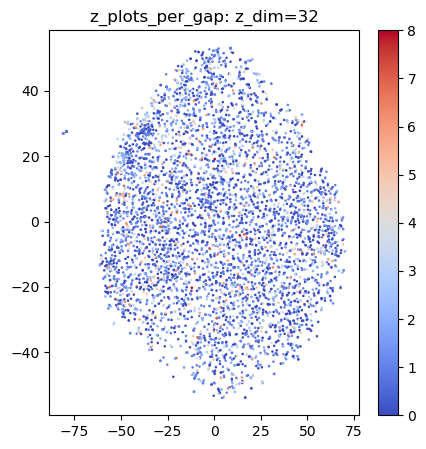

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

def reparameterize(mean, log_var):
    # log_varは実数全部とるがexpすることで正数のみ(STDは正数じゃないといけない)
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mean + eps * std

model.eval()

z_list = []
labels = []
label_name = "gap"
for i, (x, black_rank, white_rank, move) in enumerate(tqdm(valid_dataset)):
    if i > 5000: break
    # if move < 150: continue

    rank = (black_rank + white_rank) / 2
    gap = abs(black_rank - white_rank)
    label = move if label_name=="move" else rank if label_name=="rank" else gap
    labels.append(label)

    x = torch.from_numpy(x).float()
    x = x.unsqueeze(0)
    x = x.to(device)
    y, z_mu, z_logvar = model(x)
    # z = reparameterize(z_mu, z_logvar)
    z = z_mu
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

# 'TSNE' または 'PCA'
REDUC = 'TSNE' 
if z_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif z_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")



plt.figure(figsize=(5,5))

# 色スケールいろいろためす
# cmap = plt.cm.hot
cmap = plt.cm.coolwarm
vmin, vmax = min(labels), max(labels)
colors = [cmap((label - vmin) / (vmax - vmin)) for label in labels]
plt.scatter(*z_reduc, s=0.7, c=colors)

# 凡例
# for i in range(len(colors)): plt.scatter([],[], c=colors[i], label=i)
# plt.legend()

# 凡例の代わりにカラーバー
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, ax=plt.gca())  # 現在の軸にカラーバーを追加

plt.title(f"z_plots_per_{label_name}: z_dim={z_dim}")
plt.savefig(f"figures/z_plots_per_{label_name}.png")

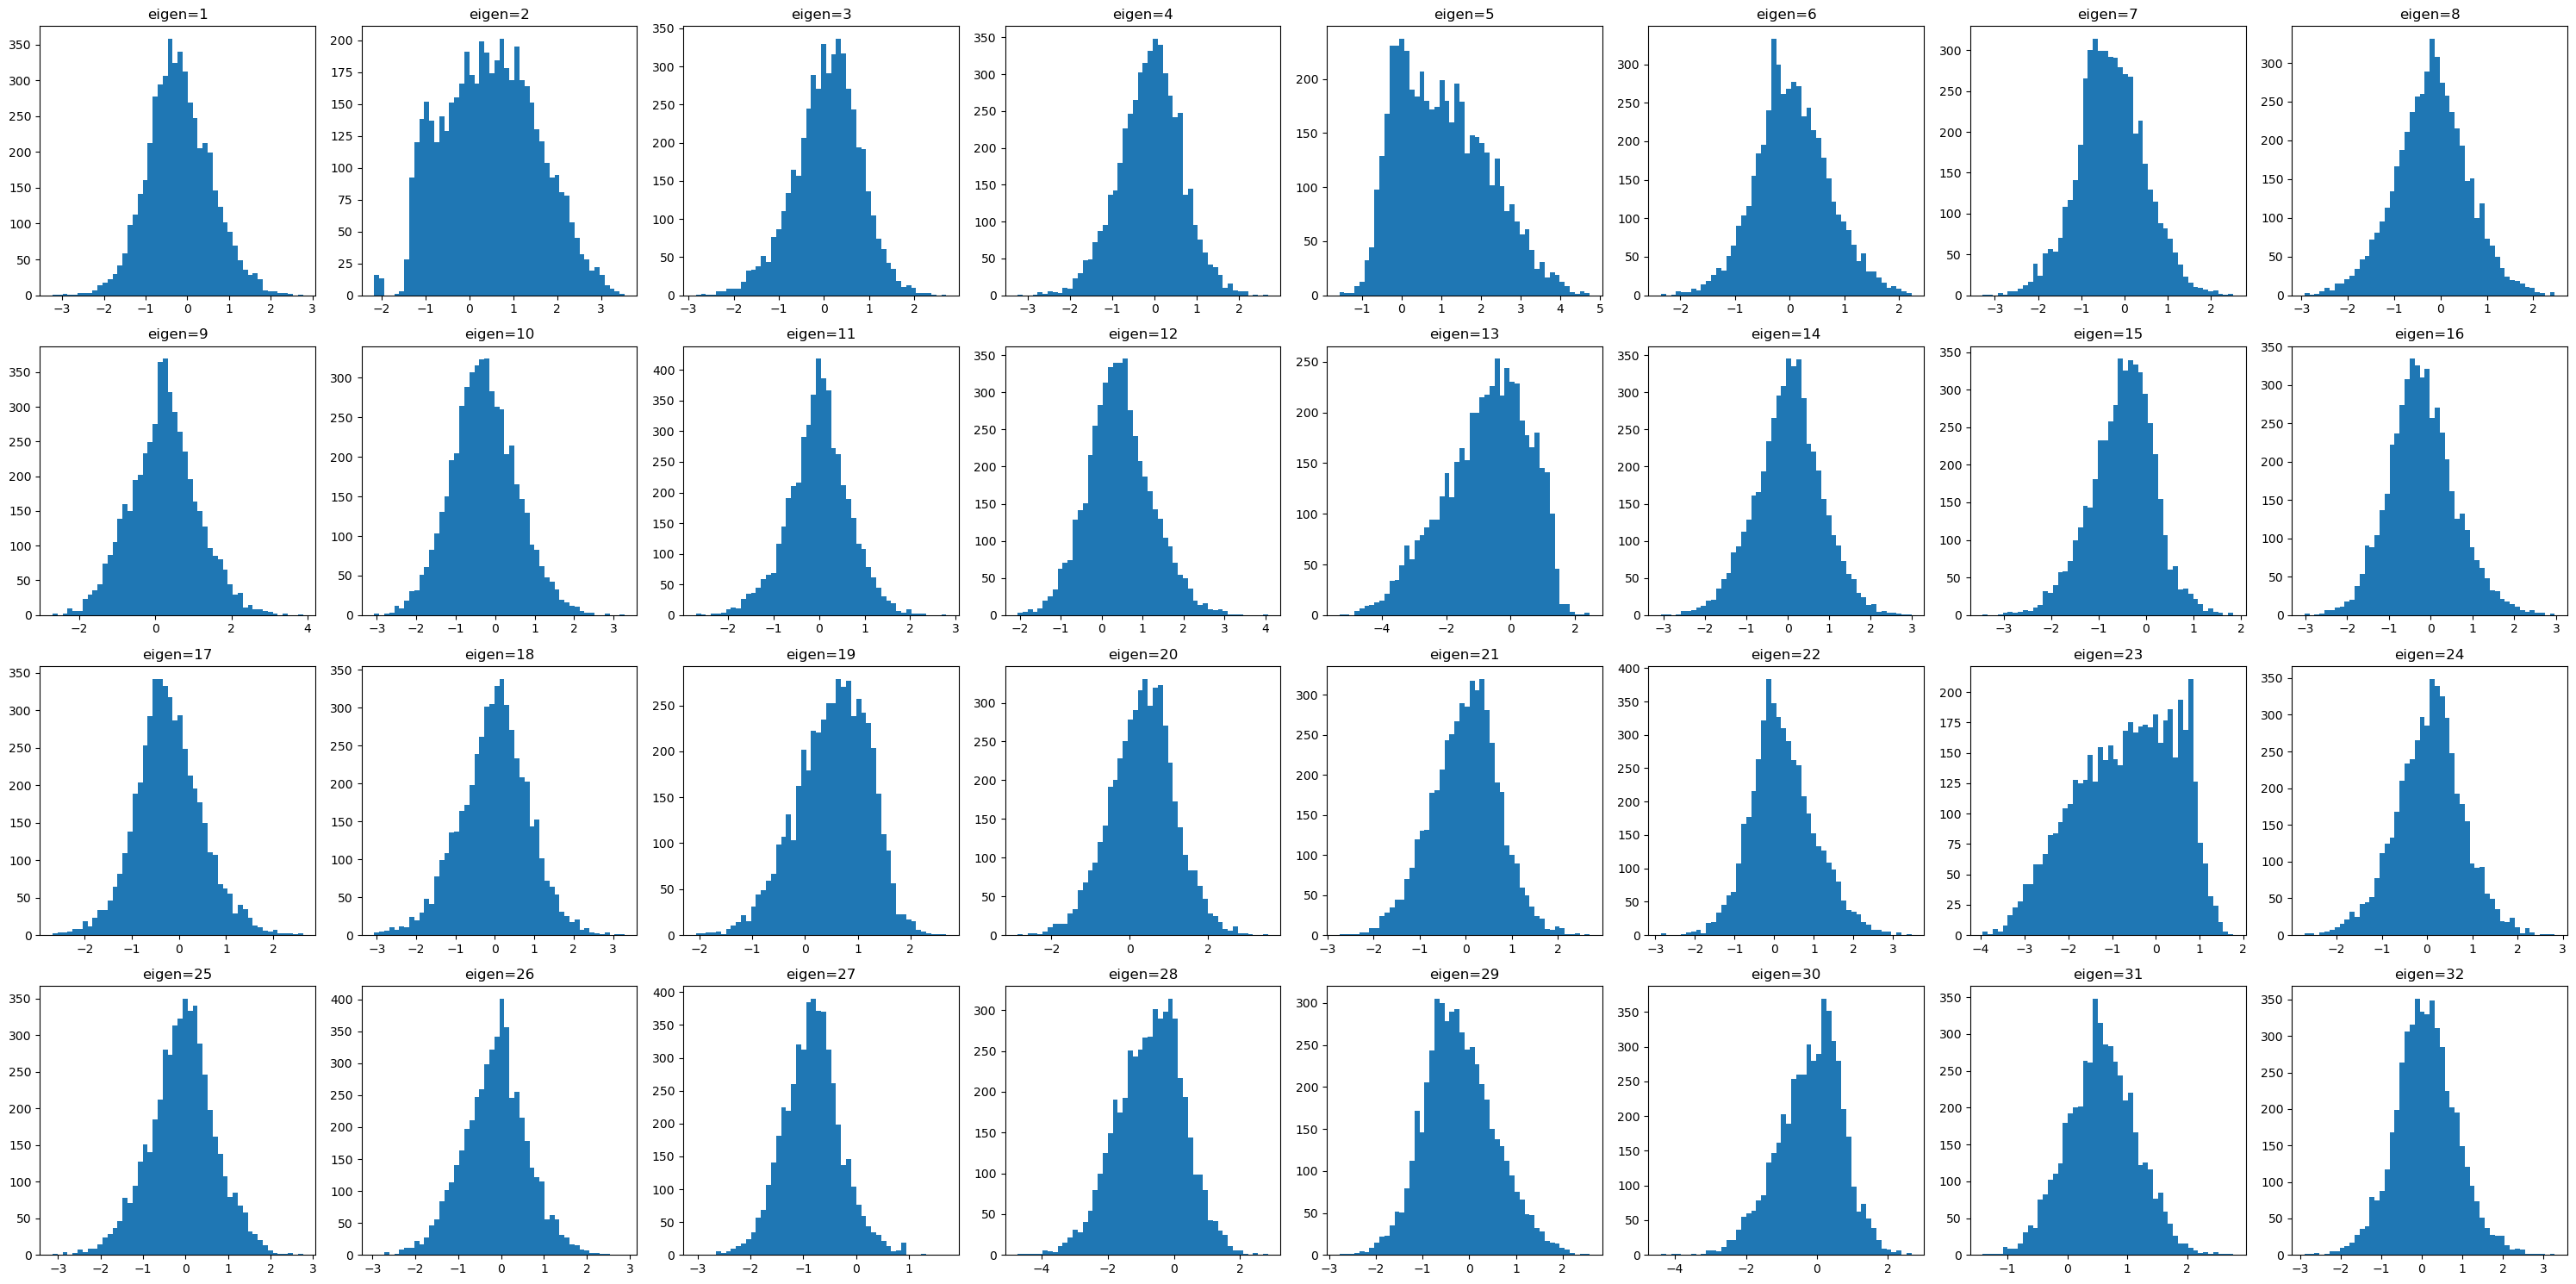

In [16]:
# z_dim の定義
z_dim = 32

# 8x8のサブプロットを作成
fig, axes = plt.subplots(4, 8, figsize=(30, 15))

# 各eigenベクトルに対してヒストグラムを描画
for i in range(z_dim):
    row, col = divmod(i, 8)  # サブプロットの行と列を計算
    ax = axes[row, col]
    z_per_eigen = z_val[:, i]
    vmin, vmax = min(z_per_eigen), max(z_per_eigen)
    ax.hist(z_per_eigen, bins=50, range=(vmin, vmax))
    ax.set_title(f"eigen={i+1}")

plt.tight_layout()
plt.savefig(f"figures/z_hist.png")
# plt.show()



In [ ]:
len(valid_dataset)

Zをランダムサンプリング

In [ ]:
from src.board import visualize_matrix

# ランダムな潜在変数 z をサンプリング
# ここでの z_dim は、モデルで使用されている潜在空間の次元数
z = torch.randn(1, z_dim).to(device)

# 学習済みのモデルの decoder 部分を使用して z を再構成
with torch.no_grad():  # 勾配計算を行わない
    model.eval()
    y = model.decoder(z)

y = y.cpu().detach().numpy()


# yの閾値処理
th = 0.25
y[y >= th] = 1
y[y < th] = 0

print("z_dim:", z_dim)
# print(z)

black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)
